In [84]:
import networkx as nx
import numpy as np
import helper_functions as hf 
COLORS="brgymcbrgymc"

import importlib
importlib.reload(hf)

<module 'helper_functions' from '/home/lema/Documents/diplomska/helper_functions.py'>

[(1, 3), (3, 4), (3, 5), (2, 3), (4, 5), (5, 6), (5, 7)]
[[1. 1. 0. 0.]
 [0. 1. 0. 1.]
 [1. 0. 1. 0.]
 [0. 0. 1. 1.]
 [0. 1. 0. 1.]
 [1. 1. 0. 0.]
 [0. 0. 1. 1.]] [[1. 1. 0. 0.]
 [0. 0. 1. 1.]] [1, 1, 1, 1, 1, 1, 1] [1, 2, 1, 4, 5, 6, 7] [1, 1]
[(1, 3), (3, 5), (5, 6)]
[(1, 3), (3, 4), (4, 5), (5, 6)]
[(3, 5), (2, 3), (5, 7)]
[(3, 4), (2, 3), (4, 5), (5, 7)]


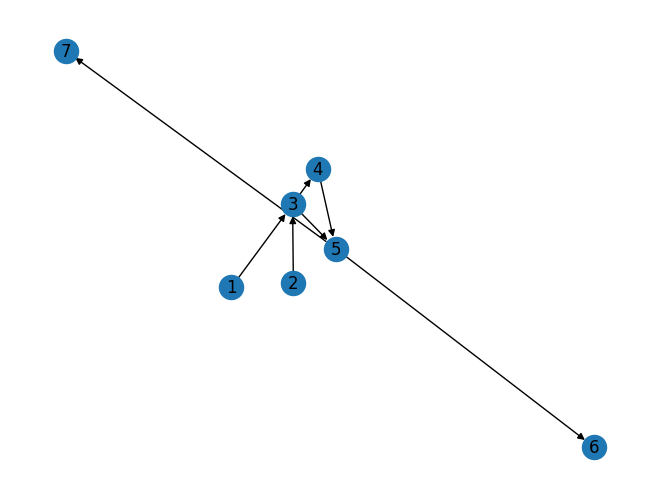

In [227]:

G = nx.DiGraph()
# G.add_edges_from([(1,3),(2,3),(3,4),(4,5),(3,5),(5,6),(5,7),(3,1),(3,2),(4,3),(5,4),(5,3),(6,5),(7,5)])
G.add_edges_from([(1,3),(2,3),(3,4),(4,5),(3,5),(5,6),(5,7)])


print(G.edges())
#nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, name = 'c')
nx.set_edge_attributes(G, {e: (i+1) for i,  e in enumerate(G.edges())}, name = 'c')
nx.set_edge_attributes(G, {(3,5):1}, name = 'c')
nx.set_edge_attributes(G, {e: 1 for e in G.edges()}, name = 't')
x = list(G.edges)

nx.draw(G,with_labels=True)

ZK = [(1,6,1),(2,7,1)] # z,k,a

Q,B,t,c,a = hf.sestavi_QBtca(ZK, G)
print(Q,B,t,c,a)

for i in range(Q.shape[1]):
    print(hf.binary_vector_to_edges(Q[:,i],G.edges()))

        


In [205]:
#c = [1, 3, 1, 1, 3, 1, 3]
#t = [1, 1, 1, 1, 0.5, 1, 1]
#Q = [[1, 1, 0, 0], [0, 0, 1, 1], [1, 0, 1, 0], [1, 0, 1, 0], [0, 1, 0, 1], [1, 1, 0, 0], [0, 0, 1, 1]]
#B = [[1, 1, 0, 0], [0, 0, 1, 1]]


paths = hf.poklici_linprog(ZK,G)


7.0 [1. 0. 0. 1.] Optimization terminated successfully. (HiGHS Status 7: Optimal)


7.0 [1. 0. 0. 1.] Optimization terminated successfully. (HiGHS Status 7: Optimal)


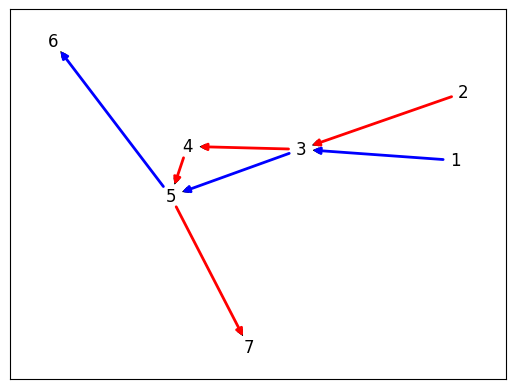

In [220]:
paths = hf.poklici_linprog(ZK,G,edges_mode=True)
hf.my_nx_draw(G,paths,with_labels=True,with_nodes=False)

In [221]:
# incidence_matrix = []
# for e in G.edges():
#     incidence_matrix.append(hf.edge_to_incidence_vector(e,list(G.nodes)))
# incidence_matrix = np.column_stack(incidence_matrix)
# neki = nx.incidence_matrix(G)
# print(neki.todense())
# incidence_matrix

In [229]:
M = hf.sparse_incidence_matrix(G.nodes(),G.edges())
M.todense()

array([[ 1,  0,  0,  0,  0,  0,  0],
       [-1,  1,  1, -1,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0,  0],
       [ 0, -1,  0,  0,  1,  0,  0],
       [ 0,  0, -1,  0, -1,  1,  1],
       [ 0,  0,  0,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  0,  0, -1]])

In [230]:
ZK = [(1,6,1),(2,7,1)]
a = [a for _,_,a in ZK]
M_ZK = hf.sparse_incidence_matrix(G.nodes(),[(z,k) for z, k, _ in ZK],factor=a)
M_ZK.todense()

array([[ 1,  0],
       [ 0,  0],
       [ 0,  1],
       [ 0,  0],
       [ 0,  0],
       [-1,  0],
       [ 0, -1]])

In [190]:
M.shape, X0.shape, M_ZK.shape

((7, 14), (14, 2), (7, 2))

In [295]:
# problematicen je izbor zacetnega priblizka, vecinoma se zatekne v lokalnem minimumu
import numpy as np
from scipy.optimize import minimize

# Definiramo funkcijo, ki jo želimo minimizirati
t = np.array([[1,1,30,1,1,1,1]]).T
c = np.array([[1,1,1,1,1,1,1]]).T * 2
def f(x):
    X = x.reshape(len(t),len(ZK))
    return np.sum(t.T@X)

# X0 = np.array([[1,0],[0,0],[1,1],[0,1],[0,0],[1,0],[0,1]])
# x0 = X0.reshape(-1)
x0 = np.random.rand(len(t) * len(ZK))
print(x0)

# Definiramo omejitve, če so potrebne (npr. X mora biti pozitiven)
#X >= 0

constraints = []
constraints =  [{'type': 'ineq', 'fun': lambda x: x}]
def con1(x):
    X = x.reshape(len(t),len(ZK))
    m = X0.shape[1]
    unit = np.ones((m, 1))
    r = c - X@unit
    return np.repeat(r,x.size//r.size)
constraints.append({'type': 'ineq', 'fun': con1})
def con2(x):
    X = x.reshape(len(t),len(ZK))
    r = M@X - M_ZK
    r = r.reshape(-1)
    return np.repeat(r,x.size//r.size)
constraints.append({'type': 'eq', 'fun': con2})
print(constraints)
res = minimize(f, x0, method='SLSQP', constraints=constraints, bounds=np.array((np.zeros(x0.size),np.ones(x0.size))).T)

# Izpišemo optimalno rešitev
print('Optimalna rešitev:')
print(res.x, res.fun, res.message)


def smart_round(x):
    x[x > 0.5] = 1
    x[x < 0.5] = 0
    return x
round_x = smart_round(res.x)
f(round_x)

[0.86635917 0.49907713 0.50181978 0.66161913 0.23037793 0.59612708
 0.15174096 0.89748107 0.58871346 0.75610951 0.07410365 0.07029253
 0.20783415 0.88421254]
[{'type': 'ineq', 'fun': <function <lambda> at 0x7fa80451c8b0>}, {'type': 'ineq', 'fun': <function con1 at 0x7fa807164310>}, {'type': 'eq', 'fun': <function con2 at 0x7fa807092200>}]
Optimalna rešitev:
[1.        0.        1.        0.7154537 0.        0.2845463 0.
 1.        1.        0.7154537 1.        0.        0.        1.       ] 15.967296518985552 Optimization terminated successfully


8.0